In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd /home/mabitbol/GBT-S140/analysis/

/home/mabitbol/GBT-S140/analysis


In [3]:
import foregrounds as fg
from scipy.optimize import curve_fit
import emcee
import corner

In [34]:
from __future__ import unicode_literals

figsize(16, 10)

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
    
rcParams['xtick.labelsize'] = 20
rcParams['xtick.major.size'] = 10
rcParams['xtick.major.width'] = 1
rcParams['xtick.major.pad'] = 0
rcParams['xtick.minor.size'] = 5
rcParams['xtick.minor.width'] = 1

rcParams['ytick.labelsize'] = 20
rcParams['ytick.major.size'] = 10
rcParams['ytick.major.width'] = 1
rcParams['ytick.major.pad'] = 0
rcParams['ytick.minor.size'] = 5
rcParams['ytick.minor.width'] = 1

rcParams['legend.fontsize'] = 24
rcParams['legend.borderaxespad'] = 1

rcParams['axes.labelsize'] = 24
rcParams['axes.titlesize'] = 24

In [5]:
bigfs = np.array([  4.08000000e+08,   1.42000000e+09,   4.57500000e+09,
         5.62500000e+09,   6.12500000e+09,   2.84000000e+10,
         4.41000000e+10,   7.04000000e+10,   1.43000000e+11,
         2.17000000e+11,   3.53000000e+11,   5.45000000e+11,
         8.57000000e+11,   1.25000000e+12,   2.14200000e+12])

In [6]:
bigdata = np.array([  1.83800000e+01,   2.06000000e+01,   1.72400000e+01,
         1.76000000e+01,   1.88800000e+01,   3.08599636e+01,
         2.74261644e+01,   2.71004995e+01,   9.32391011e+01,
         4.21696840e+02,   1.75473069e+03,   5.81715160e+03,
         1.88896531e+04,   4.22341383e+04,   7.17476918e+04])

In [7]:
bigerrs = array([  2.60000000e+00,   2.10000000e+00,   2.00000000e+00,
         2.00000000e+00,   2.00000000e+00,   1.12784119e+00,
         1.04320556e+00,   1.20346015e+00,   4.66552084e+00,
         1.88878328e+01,   7.63127567e+01,   2.42778825e+02,
         7.41098943e+02,   9.77062391e+02,   1.33135819e+03])

In [8]:
beam = pi*((45./60.)*pi/180.)**2
beam2 = pi*((1./60./60.)*pi/180.)**2

In [9]:
def signal(freqs, EM, Asd, nup, Ad, Bd, Td, Acmb):
    fffit = fg.freefreep(freqs, EM=EM, Te=8000)
    amefit = fg.ame(freqs, Asd=Asd, nup=nup) 
    dustfit = fg.thermal_dust(freqs, Ad=Ad, Bd=Bd, Td=Td)
    ccmb = fg.cmb(freqs, A=Acmb)
    return (fffit + dustfit + amefit + ccmb) * beam

In [10]:
def signal2(freqs, EM1, EM2, abeam, Ad, Bd, Td, Acmb):
    fffit = fg.freefreep(freqs, EM=EM1, Te=8000) * beam
    fffit2 = fg.freefreep(freqs, EM=EM2, Te=8000) * abeam
    dustfit = fg.thermal_dust(freqs, Ad=Ad, Bd=Bd, Td=Td) * beam
    ccmb = fg.cmb(freqs, A=Acmb) * beam
    return fffit + fffit2 + dustfit + ccmb

In [11]:
pn = np.array([100., 1.e-3, 30.e9, 1.e-4, 2., 20., 30.e-6])
x = curve_fit(signal, bigfs, bigdata, p0=pn, sigma=bigerrs, absolute_sigma=True)
pfit3 = x[0]

In [12]:
pn2 = np.array([100., 1.e9, 5.e-10, 1.e-4, 2., 20., 30e-6])
y = curve_fit(signal2, bigfs, bigdata, p0=pn2, sigma=bigerrs, absolute_sigma=True)
pfit4 = y[0]

In [13]:
print "EM, Asd, nup, Ad, Bd, Td, Acmb"
print pfit3

EM, Asd, nup, Ad, Bd, Td, Acmb
[  3.54569885e+02   1.38750614e-03   3.28036674e+10   1.20807695e-03
   1.47190920e+00   2.36487548e+01   3.69110756e-05]


In [14]:
print "EM1, EM2, abeam, Ad, Bd, Td, Acmb"
print pfit4

EM1, EM2, abeam, Ad, Bd, Td, Acmb
[  3.19229178e+02   8.06524474e+08   3.84139531e-10   1.25217773e-03
   1.29582995e+00   2.56351539e+01  -2.16567322e-04]


In [15]:
np.sqrt(pfit4[2] / pi) * 180. / pi * 60.

0.038013989247525158

In [16]:
figsize(8, 6)

In [17]:
def lnprior2(theta):
    EM1, EM2, abeam, Ad, Bd, Td, Acmb = theta
    if EM1 < 0 or EM1 > 1e4:
        return np.inf
    if EM2 < 1e4 or EM2 > 1e11:
        return np.inf
    if abeam < 0 or abeam > 1e-5:
        return np.inf
    if Ad < 0 or Ad > 10:
        return np.inf
    if Bd < 0 or Bd > 10:
        return np.inf
    if Td < 1 or Td > 100:
        return np.inf
    if np.abs(Acmb) > 10:
        return np.inf
    return 0.

In [18]:
def lnprob2(theta, x, y, yerr):
    lp = lnprior2(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike2(theta, x, y, yerr)

In [19]:
def lnlike2(theta, x, y, yerr):
    EM1, EM2, abeam, Ad, Bd, Td, Acmb = theta
    fffit = fg.freefreep(x, EM=EM1, Te=8000.) * beam
    fffit2 = fg.freefreep(x, EM=EM2, Te=8000.) * abeam
    dustfit = fg.thermal_dust(x, Ad=Ad, Bd=Bd, Td=Td) * beam
    ccmb = fg.cmb(x, A=Acmb) * beam
    model = fffit + fffit2 + dustfit + ccmb
    return -0.5 * np.sum((y-model)**2 / (yerr**2))

In [20]:
ndim, nwalkers = 7, 128
pos = [pfit4 * (1. + 1.e-3*np.random.randn(ndim)) for i in range(nwalkers)]

In [21]:
sampler1 = emcee.EnsembleSampler(nwalkers, ndim, lnprob2, args=(bigfs, bigdata, bigerrs))

In [22]:
sampler1.run_mcmc(pos, 2**14);

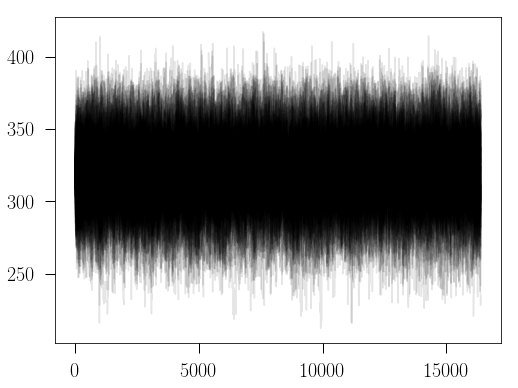

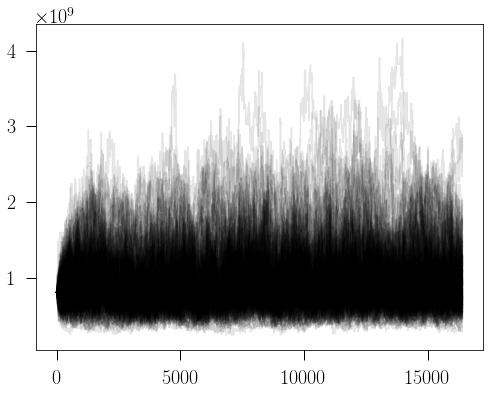

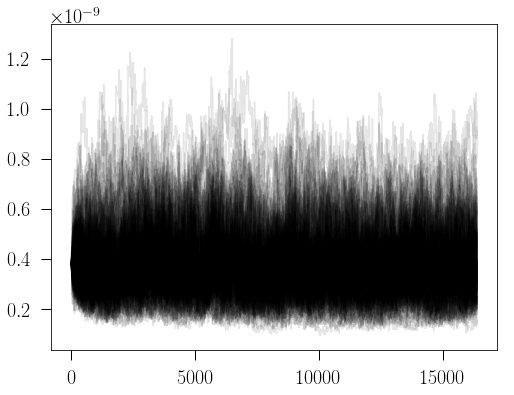

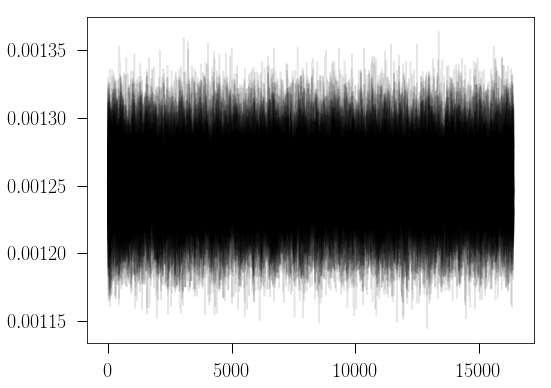

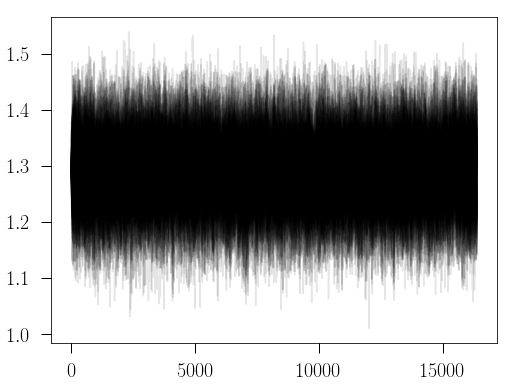

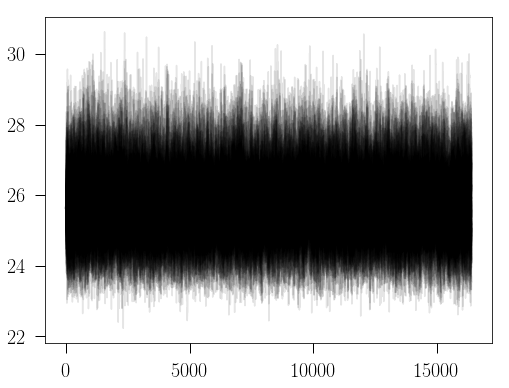

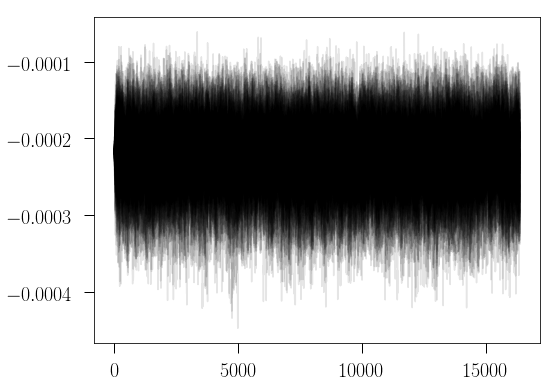

In [23]:
for k in range(ndim):
    figure()
    plot(sampler1.chain[:,:,k].T, color='k', alpha=0.1);

In [24]:
samples1 = sampler1.chain[:, 2000:, :].reshape((-1, ndim))

In [38]:
datas = samples1.copy()

In [39]:
datas[:, 1] *= 1e-9
datas[:, 2] *= 1e9
datas[:, 3] *= 1e3
datas[:, 6] *= 1e6

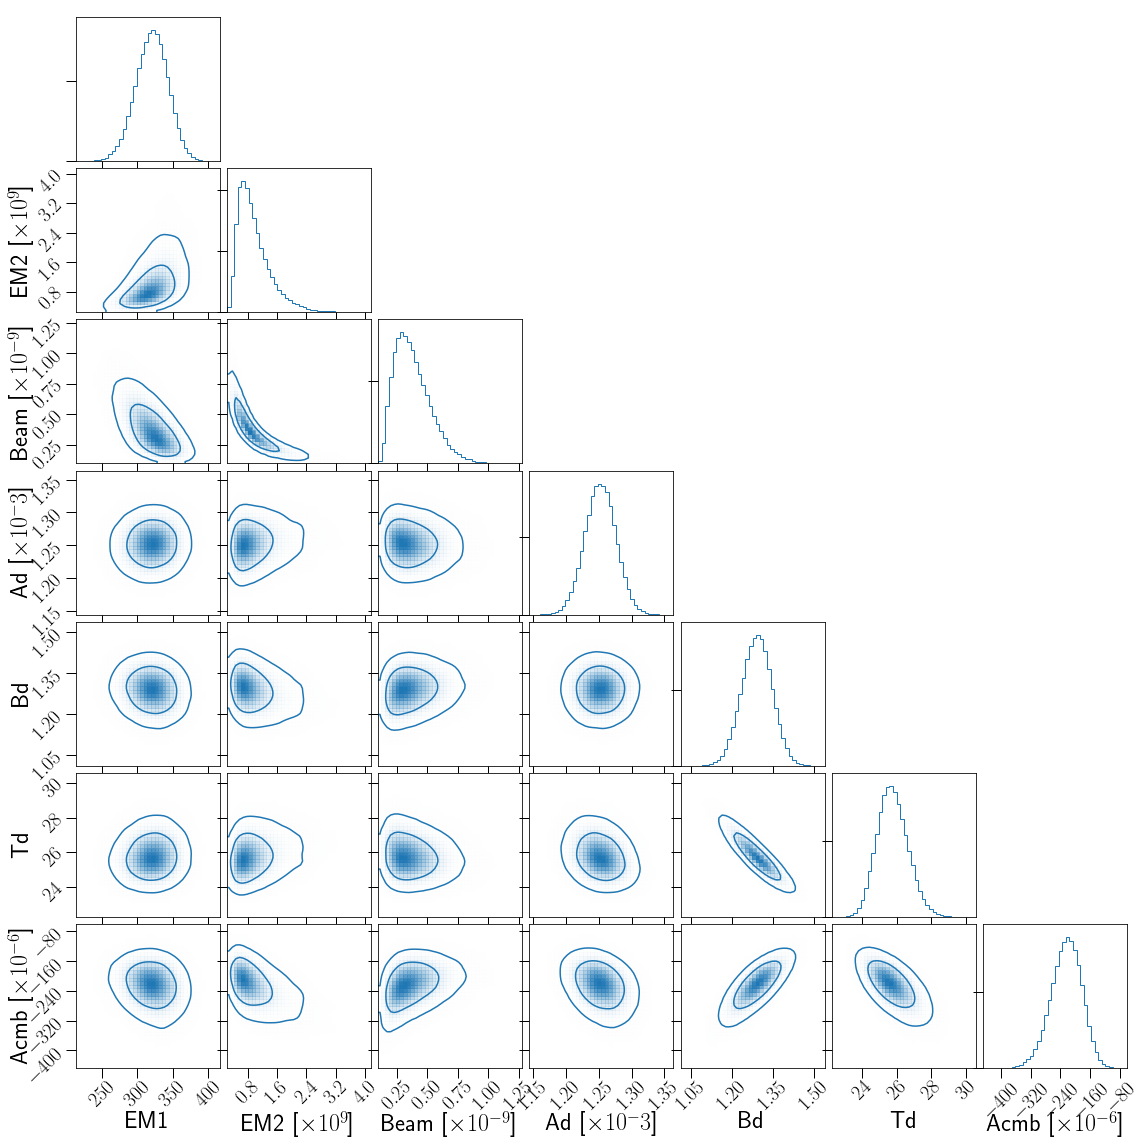

In [50]:
fig = corner.corner(datas, plot_datapoints=False, bins=40, levels=[0.68,0.95], smooth=1.,\
                    labels=["EM1", "EM2 [$\\times 10^9$]", "Beam [$\\times 10^{-9}$]", "Ad [$\\times 10^-3$]", \
                            "Bd", "Td", "Acmb [$\\times 10^{-6}$]"], color='C0')
savefig('/home/mabitbol/GBT-S140/notebooks/UCHII_posterior.pdf', format='pdf')

In [67]:
print "EM1, EM2, abeam, Ad, Bd, Td, Acmb"
print pfit4
map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples1, [16, 50, 84], axis=0)))

EM1, EM2, abeam, Ad, Bd, Td, Acmb
[  3.19229178e+02   8.06524474e+08   3.84139531e-10   1.25217773e-03
   1.29582995e+00   2.56351539e+01  -2.16567322e-04]


[(320.68594600903896, 22.317215731990359, 23.5245246336371),
 (872848078.31885529, 526673252.66142368, 297645304.01432848),
 (3.5688641701687308e-10, 1.7345106741846078e-10, 1.2093457467647144e-10),
 (0.0012522894185516616, 2.3383853786887628e-05, 2.3411419306358172e-05),
 (1.2903277654772172, 0.054301056094837374, 0.056318448658584153),
 (25.711580367184851, 0.93322584218395477, 0.83471087199233196),
 (-0.00022315296664538299, 3.933478947353765e-05, 4.2940870194339809e-05)]

In [80]:
np.sqrt(np.array([5.0465435704712113e-10, 8.8948457380303142e-10, 2.6431245527012805e-10]) / pi) * 180. / pi * 60. * 60.

array([ 2.61425056,  3.47071863,  1.8919472 ])

In [38]:
#arcseconds...

In [42]:
def lnprior(theta):
    EM, Asd, nup, Ad, Bd, Td, Acmb = theta
    if EM < 0 or EM > 1e9:
        return np.inf
    if Asd < 0 or Asd > 1e3:
        return np.inf
    if nup < 1e9 or nup > 1e11:
        return np.inf
    if Ad < 0 or Ad > 1e3:
        return np.inf
    if Bd < 0 or Bd > 100:
        return np.inf
    if Td < 0 or Td > 1000:
        return np.inf
    if np.abs(Acmb) > 1e3:
        return np.inf
    return 0.

In [43]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [44]:
def lnlike(theta, x, y, yerr):
    EM, Asd, nup, Ad, Bd, Td, Acmb = theta
    fffit = fg.freefreep(x, EM=EM, Te=8000.)
    dustfit = fg.thermal_dust(x, Ad=Ad, Bd=Bd, Td=Td)
    amefit = fg.ame(x, Asd=Asd, nup=nup) 
    ccmb = fg.cmb(x, A=Acmb)
    model = (fffit + dustfit + amefit + ccmb) * beam
    return -0.5 * (np.sum((y - model)**2. * yerr**-2.))

In [45]:
ndim, nwalkers = 7, 64
pos = [pfit3 * (1. + 1.e-2*np.random.randn(ndim)) for i in range(nwalkers)]

In [77]:
amefit = fg.ame(32.8e9, Asd=1370e-6, nup=32.8e9) * beam

In [78]:
amefit

16.55348544156255

In [46]:
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(bigfs, bigdata, bigerrs))

In [47]:
sampler2.run_mcmc(pos, 2**12);

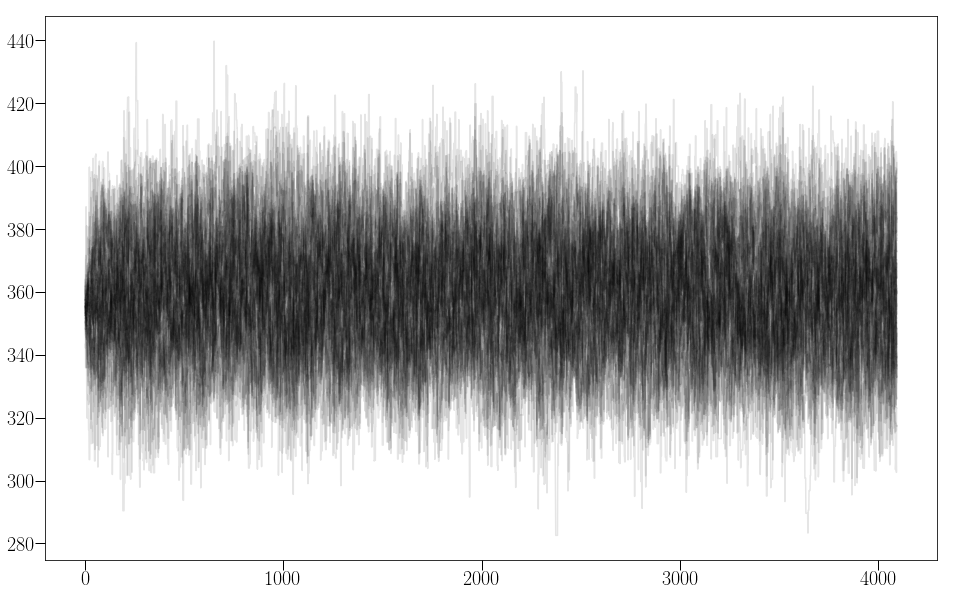

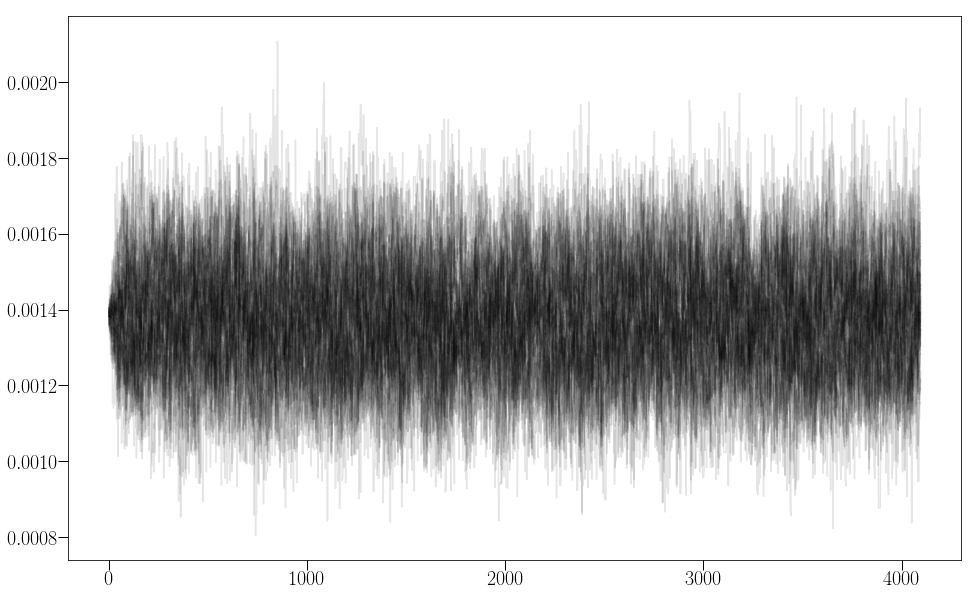

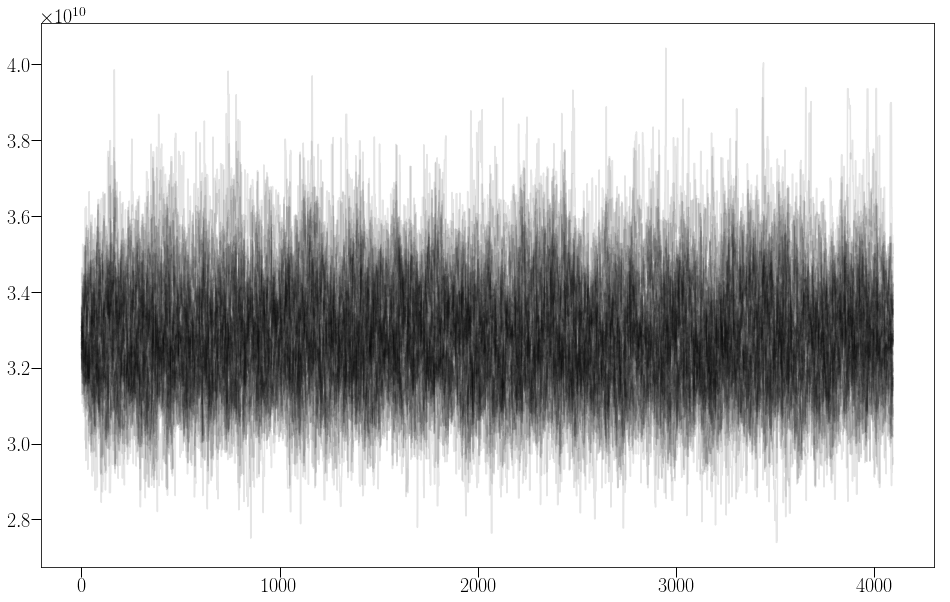

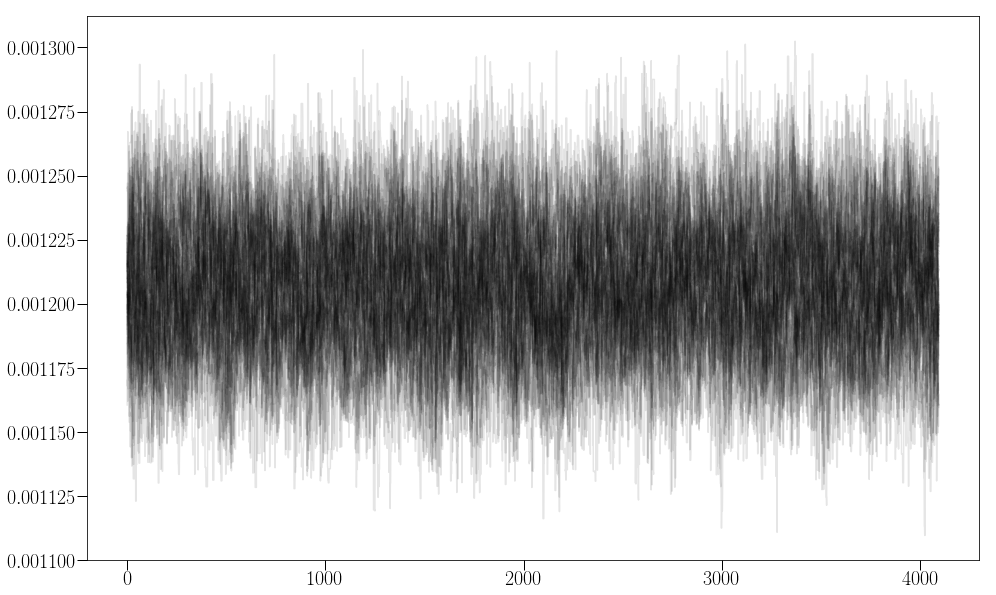

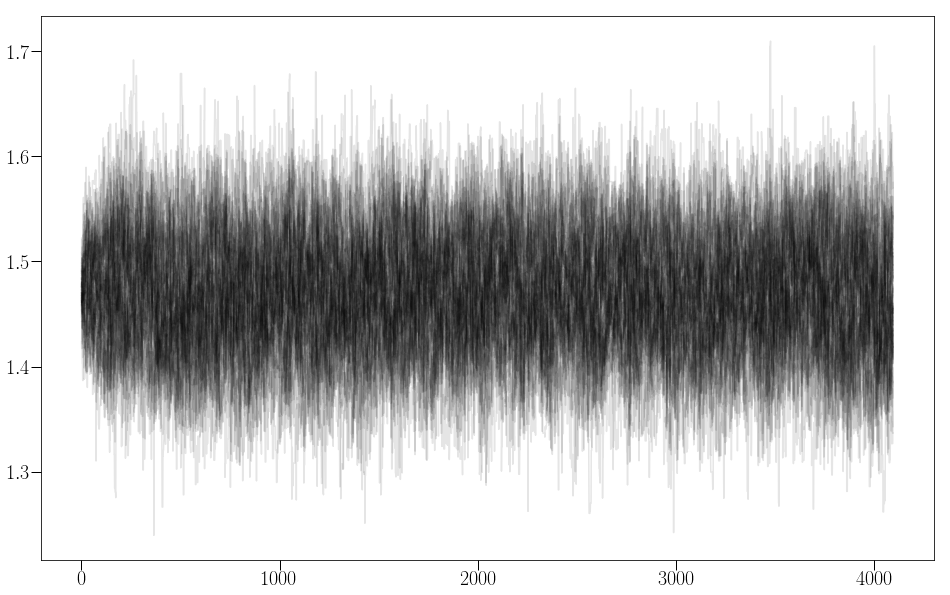

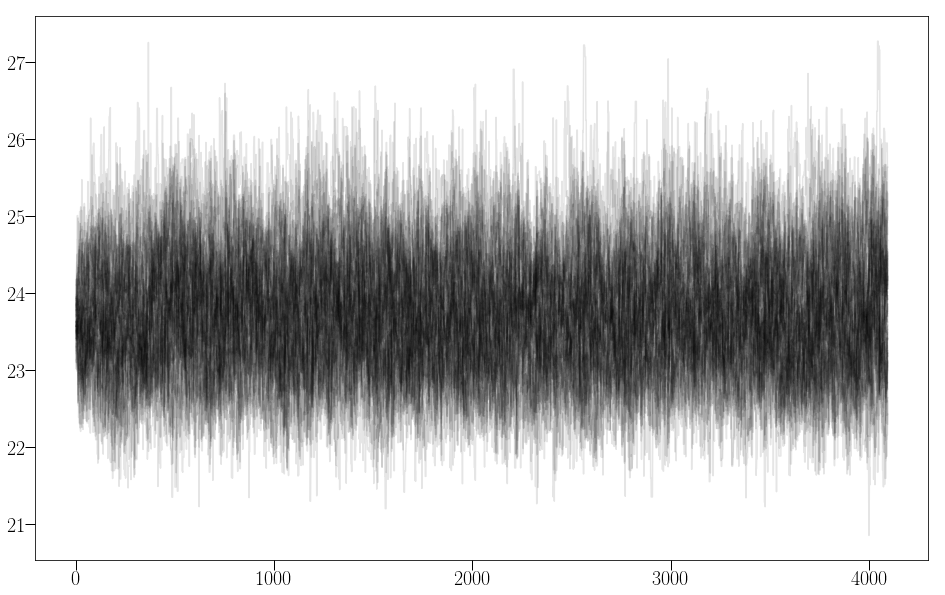

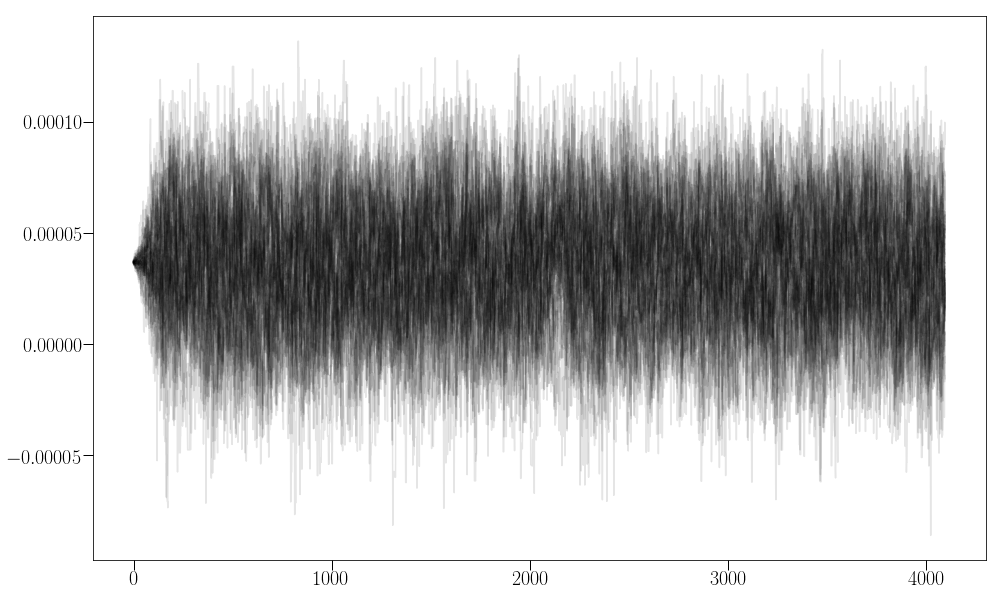

In [49]:
for k in range(ndim):
    figure()
    plot(sampler2.chain[:,:,k].T, color='k', alpha=0.1);

In [51]:
samples2 = sampler2.chain[:, 1000:, :].reshape((-1, ndim))

In [58]:
datas2 = samples2.copy()

In [59]:
datas2[:, 1] *= 1e3
datas2[:, 2] *= 1e-9
datas2[:, 3] *= 1e3
datas2[:, 6] *= 1e6

In [ ]:
fig = corner.corner(datas2, plot_datapoints=False, bins=40, levels=[0.68,0.95], smooth=1.,\
                    labels=["EM", "Asd [$\\times 10^{-3}$]", "nup [$\\times 10^{-9}$]", "Ad [$\\times 10^{-3}$]", \
                            "Bd", "Td", "Acmb [$\\times 10^{-6}$]"], color='midnightblue')
#savefig('/home/mabitbol/GBT-S140/notebooks/spinningdust_posterior.pdf', format='pdf')

In [68]:
print "EM, Asd, nup, Ad, Bd, Td, Acmb"
print pfit3
map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples2, [16, 50, 84], axis=0)))

EM, Asd, nup, Ad, Bd, Td, Acmb
[  3.54569885e+02   1.38750614e-03   3.28036674e+10   1.20807695e-03
   1.47190920e+00   2.36487548e+01   3.69110756e-05]


[(359.16325341634945, 17.903878877099487, 17.871106108536651),
 (0.0013710284870170515, 0.00014212799272213467, 0.00014039987518290318),
 (32773469883.209545, 1381716181.4430008, 1293514562.8972511),
 (0.0012071230763727951, 2.3152625183450824e-05, 2.3298113254778324e-05),
 (1.4693983136241786, 0.053515644156436837, 0.052915217761379196),
 (23.689794413701705, 0.73769860165582557, 0.69467607180777691),
 (3.5596429828790456e-05, 2.5170221528407365e-05, 2.6244474019596492e-05)]

In [67]:
print "EM1, EM2, abeam, Ad, Bd, Td, Acmb"
print pfit4
map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples1, [16, 50, 84], axis=0)))

EM1, EM2, abeam, Ad, Bd, Td, Acmb
[  3.19229178e+02   8.06524474e+08   3.84139531e-10   1.25217773e-03
   1.29582995e+00   2.56351539e+01  -2.16567322e-04]


[(320.68594600903896, 22.317215731990359, 23.5245246336371),
 (872848078.31885529, 526673252.66142368, 297645304.01432848),
 (3.5688641701687308e-10, 1.7345106741846078e-10, 1.2093457467647144e-10),
 (0.0012522894185516616, 2.3383853786887628e-05, 2.3411419306358172e-05),
 (1.2903277654772172, 0.054301056094837374, 0.056318448658584153),
 (25.711580367184851, 0.93322584218395477, 0.83471087199233196),
 (-0.00022315296664538299, 3.933478947353765e-05, 4.2940870194339809e-05)]

In [70]:
np.sqrt(np.array([3.5688641701687308e-10, 1.7345106741846078e-10, 1.2093457467647144e-10]) / pi) * 180. / pi * 60. * 60.

array([ 2.19844298,  1.53263481,  1.27975088])

In [71]:
# arc seconds